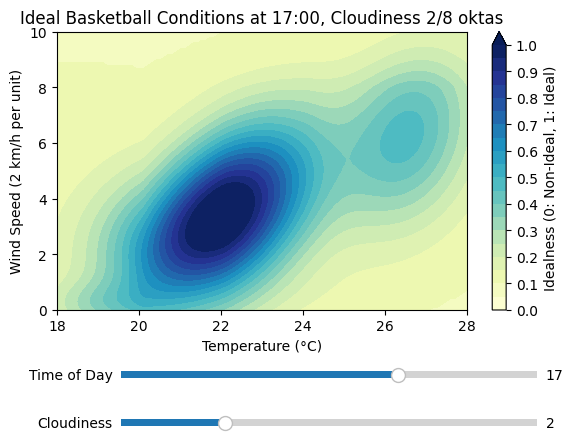

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Central wind scale constant
WIND_SCALE = 2  # 1 unit in the original scale equals 5 km/h

# Constants
TEMP_MIN, TEMP_MAX = 18, 28
WIND_MIN, WIND_MAX = 0, 5 * WIND_SCALE  # 0 to 5 * WIND_SCALE km/h
TIME_MIN, TIME_MAX = 7, 22
CLOUDINESS_MIN, CLOUDINESS_MAX = 0, 8
FLEXIBILITY_FACTOR = 0.1

# Temperature constants
TEMP_IDEAL_1, TEMP_IDEAL_2 = 22, 27
TEMP_SPREAD_1, TEMP_SPREAD_2 = 6, 3  # Reduced spread for higher temperatures
TEMP_SKEW_FACTOR = 1.5
MORNING_TEMP_START, MORNING_TEMP_RATE = 18, 0.75
EVENING_TEMP_START, EVENING_TEMP_RATE = 26, 0.75
COOL_EVENING_TEMP, COOL_EVENING_SPREAD = 19, 2

# Wind constants (adjusted for wind scale)
WIND_IDEAL_BASE, WIND_IDEAL_FACTOR = 1 * WIND_SCALE, 2.8 * WIND_SCALE
WIND_SPREAD_BASE, WIND_SPREAD_FACTOR = 1.8 * WIND_SCALE**2, 1 * WIND_SCALE**2

# Time constants
TIME_FACTOR_TEMP_THRESHOLD = 22
TIME_FACTOR_TEMP_RANGE = 8
IDEAL_TIME_MORNING_BASE, IDEAL_TIME_MORNING_FACTOR = 9, 3
IDEAL_TIME_EVENING_BASE, IDEAL_TIME_EVENING_FACTOR = 18, 3
TIME_SPREAD_MORNING = TIME_SPREAD_EVENING = 10

# Cloudiness constants
CLOUD_SPREAD_FACTOR = 1.5
CLOUD_INTENSITY_FACTOR = 1
CLOUD_PENALTY_REDUCTION = 0.5
BOUNDARY_EXPANSION_BASE = 5

# Sun exposure constants
SUN_PENALTY_FACTOR = 0.5
SUN_PENALTY_TEMP = 25
SUN_PENALTY_SPREAD = 10

# Penalty constants (adjusted for wind scale)
TEMP_PENALTY_THRESHOLD, TEMP_PENALTY_RANGE = 28, 1.5
WIND_PENALTY_THRESHOLD, WIND_PENALTY_RANGE = 4 * WIND_SCALE, 2 * WIND_SCALE

# Time-based effects
DAYTIME_PERIOD = 12
EVENING_START, EVENING_DURATION = 17, 5
NIGHT_START, NIGHT_DURATION = 22, 2
AFTERNOON_START, AFTERNOON_DURATION = 13, 3
AFTERNOON_MAX_REDUCTION = 0.3

# New constants for temperature-wind interaction
TEMP_WIND_INTERACTION_FACTOR = 0.15
TEMP_WIND_THRESHOLD = 24

# Create a meshgrid for temperature and wind levels
temp_range = np.linspace(TEMP_MIN, TEMP_MAX, 100)
wind_range = np.linspace(WIND_MIN, WIND_MAX, 100)
T, W = np.meshgrid(temp_range, wind_range)

def idealness(temp, wind, time_of_day, cloudiness_okta):
    # Convert cloudiness from oktas to 0-1 scale
    cloudiness = cloudiness_okta / CLOUDINESS_MAX

    # Time-dependent factors
    daytime_factor = np.sin((time_of_day - 6) * np.pi / DAYTIME_PERIOD) * (1 - 0.5 * np.exp(-((time_of_day - 12) ** 2) / 2))
    evening_factor = np.clip((time_of_day - EVENING_START) / EVENING_DURATION, 0, 1)
    night_factor = np.clip((time_of_day - NIGHT_START) / NIGHT_DURATION, 0, 1)

    # Afternoon reduction factor
    afternoon_factor = np.clip(np.sin((time_of_day - 14) * np.pi / AFTERNOON_DURATION) * (1 - cloudiness), 0, AFTERNOON_MAX_REDUCTION)
    
    # Enhanced evening idealness factor
    evening_boost = 0.3 * np.sin(np.pi * evening_factor) * (1 - night_factor)

    # Cloudiness effectiveness
    cloudiness_effectiveness = 1 - 0.7 * evening_factor - 0.3 * night_factor
    effective_cloudiness = cloudiness * cloudiness_effectiveness

    # Dynamic temperature skew based on time of day
    temp_skew = TEMP_SKEW_FACTOR * daytime_factor * (1 - evening_factor)
    temp_adjusted = temp - effective_cloudiness * temp_skew

    # Adjusted sun exposure factor
    sun_exposure = np.clip(np.sin((time_of_day - 6) * np.pi / DAYTIME_PERIOD), 0, 1) * (1 - effective_cloudiness)

    # Temperature idealness with two main peaks
    temp_idealness1 = np.exp(-((temp_adjusted - TEMP_IDEAL_1) ** 2) / TEMP_SPREAD_1)
    temp_idealness2 = np.exp(-((temp_adjusted - TEMP_IDEAL_2) ** 2) / TEMP_SPREAD_2)
    
    # New temperature-wind interaction factor
    temp_wind_factor = np.clip(1 - TEMP_WIND_INTERACTION_FACTOR * np.maximum(temp_adjusted - TEMP_WIND_THRESHOLD, 0) * (wind / WIND_MAX), 0.5, 1)
    
    # Apply temperature-wind interaction factor
    temp_idealness1 *= temp_wind_factor
    temp_idealness2 *= temp_wind_factor

    # Morning low wind and temperature sensitivity
    morning_temp_component = MORNING_TEMP_START + (time_of_day - 7) * MORNING_TEMP_RATE
    morning_temp_idealness = np.exp(-((temp_adjusted - morning_temp_component) ** 2) / 5)
    morning_wind_idealness = np.exp(-(wind ** 2) / (0.3 * WIND_SCALE**2))
    morning_time_factor = np.exp(-((time_of_day - 9) ** 2) / 10)
    morning_peak = morning_temp_idealness * morning_wind_idealness * morning_time_factor
    
    # Evening low wind and temperature sensitivity
    evening_temp_component = np.clip(EVENING_TEMP_START - (time_of_day - EVENING_START) * EVENING_TEMP_RATE, TEMP_MIN, EVENING_TEMP_START)
    evening_temp_idealness = np.exp(-((temp_adjusted - evening_temp_component) ** 2) / 5)
    evening_wind_idealness = np.exp(-(wind ** 2) / (0.3 * WIND_SCALE**2))
    evening_time_factor = np.exp(-((time_of_day - 19) ** 2) / 10)
    evening_peak = evening_temp_idealness * evening_wind_idealness * evening_time_factor
    
    # Specific cool evening effect
    cool_evening_temp = np.exp(-((temp_adjusted - COOL_EVENING_TEMP) ** 2) / COOL_EVENING_SPREAD)
    cool_evening_wind = np.exp(-(wind ** 2) / (0.2 * WIND_SCALE**2))
    cool_evening_time = np.exp(-((time_of_day - 20) ** 2) / 8)
    cool_evening_effect = cool_evening_temp * cool_evening_wind * cool_evening_time
    
    # Combined cool time effect
    cool_time_effect = np.maximum(morning_peak, np.maximum(evening_peak, cool_evening_effect))
    
    # Wind idealness with temperature scaling
    wind_temp_factor = np.clip((temp_adjusted - 20) / 8, 0, 1)
    ideal_wind_speed = WIND_IDEAL_BASE + WIND_IDEAL_FACTOR * wind_temp_factor
    wind_idealness = np.exp(-((wind - ideal_wind_speed) ** 2) / (WIND_SPREAD_BASE + WIND_SPREAD_FACTOR * wind_temp_factor))

    # Time factors
    time_factor_morning = np.clip((TIME_FACTOR_TEMP_THRESHOLD - temp_adjusted) / TIME_FACTOR_TEMP_RANGE, 0, 1)
    time_factor_evening = np.clip((temp_adjusted - TIME_FACTOR_TEMP_THRESHOLD) / TIME_FACTOR_TEMP_RANGE, 0, 1)
    ideal_time_morning = IDEAL_TIME_MORNING_BASE + IDEAL_TIME_MORNING_FACTOR * time_factor_morning
    ideal_time_evening = IDEAL_TIME_EVENING_BASE + IDEAL_TIME_EVENING_FACTOR * time_factor_evening
    time_idealness_morning = np.exp(-((time_of_day - ideal_time_morning) ** 2) / TIME_SPREAD_MORNING)
    time_idealness_evening = np.exp(-((time_of_day - ideal_time_evening) ** 2) / TIME_SPREAD_EVENING)
    noon_factor = np.exp(-((time_of_day - 12) ** 2) / 2)
    time_idealness = np.where(time_of_day < 12, 
                              time_idealness_morning * (1 - noon_factor) + noon_factor, 
                              time_idealness_evening * (1 - noon_factor) + noon_factor)
    
    # Cloudiness impact
    cloud_spread_factor = 1 + CLOUD_SPREAD_FACTOR * effective_cloudiness * np.sin(effective_cloudiness * np.pi)
    cloud_intensity_factor = 1 + effective_cloudiness * CLOUD_INTENSITY_FACTOR

    # Midday effect for cloud cover
    midday_effect = np.clip(np.abs(time_of_day - 12) / 4, 0, 1) * effective_cloudiness
    temp_idealness1 *= (1 + midday_effect * (cloud_spread_factor - 1)) * cloud_intensity_factor
    temp_idealness2 *= (1 + midday_effect * (cloud_spread_factor - 1)) * cloud_intensity_factor

    # Evening clear sky bonus
    clear_sky_bonus = (1 - effective_cloudiness) * evening_factor * 0.2

    # Combine factors
    combined_idealness = (temp_idealness1 + temp_idealness2 + cool_time_effect) * wind_idealness * time_idealness
    combined_idealness += clear_sky_bonus + evening_boost
    
    # Dynamic sun exposure penalty
    sun_penalty_factor = np.clip(1 - np.abs(time_of_day - 12) / 6, 0, 1)
    sun_penalty = SUN_PENALTY_FACTOR * sun_exposure * np.exp(-((temp_adjusted - SUN_PENALTY_TEMP) ** 2) / SUN_PENALTY_SPREAD) * sun_penalty_factor
    combined_idealness -= sun_penalty

    # Penalties for extreme conditions
    cloud_penalty_reduction = 1 - CLOUD_PENALTY_REDUCTION * effective_cloudiness
    temp_penalty = np.clip((temp_adjusted - TEMP_PENALTY_THRESHOLD) / TEMP_PENALTY_RANGE, 0, 1) * cloud_penalty_reduction * (1 - evening_factor)
    wind_penalty = np.clip((wind - WIND_PENALTY_THRESHOLD) / WIND_PENALTY_RANGE, 0, 1) * cloud_penalty_reduction * (1 - 0.5 * evening_factor)
    combined_penalty = np.maximum(temp_penalty, wind_penalty)

    # Time-based penalty
    time_penalty = 0.3 * np.exp(-((time_of_day - 16) ** 2) / 4) * (1 - effective_cloudiness) * (1 - evening_factor) * (1 - np.exp(-((time_of_day - 12) ** 2) / 2))
    combined_idealness *= (1 - time_penalty)

    # Apply afternoon reduction
    combined_idealness *= (1 - afternoon_factor)

    # Final idealness
    final_idealness = combined_idealness * (1 - combined_penalty)

    # Boundary expansion with cloudiness
    boundary_expansion_factor = np.log(1 + effective_cloudiness * BOUNDARY_EXPANSION_BASE * (1 - evening_factor))
    boundary_expansion_factor = np.clip(boundary_expansion_factor, 1, 2)

    return np.clip(np.clip(final_idealness * boundary_expansion_factor, 0, 1) + FLEXIBILITY_FACTOR, 0, 1)

# Initial parameters
initial_time_of_day = 17
initial_cloudiness = 2

# Apply the idealness function to the grid for the initial time of day and cloudiness
Z_combined = idealness(T, W, initial_time_of_day, initial_cloudiness)

# Create the plot
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3)
contour_plot = ax.contourf(T, W, Z_combined, levels=np.linspace(0, 1, 21), cmap='YlGnBu', extend='max')

# Labels and title
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel(f'Wind Speed ({WIND_SCALE} km/h per unit)')
cbar = plt.colorbar(contour_plot, ticks=np.linspace(0, 1, 11))
cbar.set_label('Idealness (0: Non-Ideal, 1: Ideal)')
plt.title(f'Ideal Basketball Conditions at {initial_time_of_day}:00, Cloudiness {initial_cloudiness}/8 oktas')

# Create slider axes
ax_time_slider = plt.axes([0.2, 0.15, 0.65, 0.03], facecolor='lightgoldenrodyellow')
ax_cloudiness_slider = plt.axes([0.2, 0.05, 0.65, 0.03], facecolor='lightblue')

# Create sliders for time of day and cloudiness
time_slider = Slider(ax_time_slider, 'Time of Day', TIME_MIN, TIME_MAX, valinit=initial_time_of_day, valstep=1)
cloudiness_slider = Slider(ax_cloudiness_slider, 'Cloudiness', CLOUDINESS_MIN, CLOUDINESS_MAX, valinit=initial_cloudiness, valstep=1)

# Update function to be called when either slider's value changes
def update(val):
    global contour_plot
    time_of_day = time_slider.val
    cloudiness = cloudiness_slider.val
    Z_updated = idealness(T, W, time_of_day, cloudiness)
    
    ax.clear()
    
    contour_plot = ax.contourf(T, W, Z_updated, levels=np.linspace(0, 1, 21), cmap='YlGnBu', extend='max')
    
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(f'Wind Speed ({WIND_SCALE} km/h per unit)')
    ax.set_title(f'Ideal Basketball Conditions at {int(time_of_day)}:00, Cloudiness {cloudiness}/8 oktas')
    
    fig.canvas.draw_idle()

# Attach the update function to the sliders
time_slider.on_changed(update)
cloudiness_slider.on_changed(update)

# Show the plot with the sliders
plt.show()